# Pronósticos de series de tiempo multiples usando Prophet

# Intro

El pronóstico de múltiples series de tiempo se refiere al entrenamiento de muchos modelos de series de tiempo y la realización de predicciones. Por ejemplo, si quisiéramos predecir la cantidad de ventas de 10 productos en 5 tiendas, habrá 50 combinaciones de tienda-producto y cada combinación es una serie de tiempo. Utilizando el modelo de series de tiempo múltiples, podemos entrenar y predecir el modelo de 50 series de tiempo al mismo tiempo. Otro ejemplo es predecir los precios de varias acciones al mismo tiempo.



- ¿Cómo ejecutar pronósticos de múltiples series de tiempo usando el bucle for?
-¿Cómo configurar el multiprocesamiento y utilizar todos los núcleos de una computadora para ejecutar múltiples modelos de series temporales?
- ¿Cómo configurar PySpark para ejecutar pronósticos de múltiples series de tiempo en paralelo?

# Paso 1: instalar e importar bibliotecas


En el primer paso, instalaremos e importaremos bibliotecas.

Se instalan tres paquetes:

- `yfinance` el paquete Python para extraer datos bursátiles de Yahoo Finance.
- `prophet` es el paquete para el modelo de series temporales.
- `pyspark` es para configurar el entorno Spark.

In [1]:
# Install libraries
#%pip install yfinance prophet pyspark

Después de instalar los tres paquetes de Python, importamos las bibliotecas necesarias para este tutorial.

- `pandas` y `numpy`son para el procesamiento de datos.
- `yfinancees` para extraer datos de precios de acciones de Yahoo Finance.
- `prophet` es para construir el modelo de series de tiempo.
- `seaborn` y `matplotlib` son para visualización.
- `Pool` y `cpu_countson` para multiprocesamiento.
- `pyspark.sql.types`, `pandas_udfy` `PandasUDFTypeson` para el procesamiento paralelo de Spark.
- `tqdm` es para generar una barra de proceso para mostrar el porcentaje completado.
- `time` es para rastrear el tiempo utilizado para el modelado y la predicción.

In [2]:
# Procesamiento de datos
import pandas as pd
import numpy as np

# obtener dados
import yfinance as yf

# Modelo Prophet para pronóstico de series temporales.
from prophet import Prophet

# Visualizacion
import seaborn as sns
import matplotlib.pyplot as plt

# Multi-processing
from multiprocessing import Pool, cpu_count

# Spark
from pyspark.sql.types import *
from pyspark.sql.functions import pandas_udf, PandasUDFType

# progreso
from tqdm import tqdm

# Tiempo
from time import time


# Paso 2: extraer datos


El segundo paso extrae datos bursátiles de la API de Yahoo Finance.

- `start_date = '2022-01-01'` significa que la fecha más temprana para los datos bursátiles es el 1 de enero de 2022.

- `end_date = '2023-11-01'`significa que la última fecha para los datos bursátiles es el 31 de octubre de 2023. yfinance excluye la fecha de finalización, por lo que debemos agregar un día al último día de la fecha de finalización de los datos.

In [3]:
# Fecha Inicio datos
start_date = '2022-01-01'

# Fecha fin de los datos
end_date = '2024-08-15'

Descargaremos los precios de cierre de cinco tickers. FB es para Facebook (Meta), GOOG es para Google, ORCL es para Oracle, MSFT es para Microsoft y AMZN es para Amazon.

El objetivo del modelo de series de tiempo es predecir el precio de cierre de las cinco acciones.


In [4]:
# Descargar los datos
ticker_list = [ "META",'GOOG', 'ORCL', 'MSFT', 'AMZN']
data = yf.download(ticker_list, start=start_date, end=end_date)[['Close']]
data


[*********************100%%**********************]  5 of 5 completed


Price            Close                                                
Ticker            AMZN        GOOG        META        MSFT        ORCL
Date                                                                  
2022-01-03  170.404495  145.074493  338.540009  334.750000   87.900002
2022-01-04  167.522003  144.416504  336.529999  329.010010   88.839996
2022-01-05  164.356995  137.653503  324.170013  316.380005   86.459999
2022-01-06  163.253998  137.550995  332.459991  313.880005   86.339996
2022-01-07  162.554001  137.004501  331.790009  314.040009   87.510002
...                ...         ...         ...         ...         ...
2024-08-08  165.800003  163.839996  509.630005  402.690002  128.960007
2024-08-09  166.940002  165.389999  517.770020  406.019989  132.059998
2024-08-12  166.800003  163.949997  515.950012  406.809998  132.580002
2024-08-13  170.229996  165.929993  528.539978  414.010010  134.259995
2024-08-14  170.100006  162.029999  526.760010  416.859985  135.600006

[657 rows x 5 columns]

In [5]:
# borrar nivel superior columna
data.columns = data.columns.droplevel()
data.head()

Ticker,AMZN,GOOG,META,MSFT,ORCL
Date,,,,,
2022-01-03,170.404495,145.074493,338.540009,334.750000,87.900002
2022-01-04,167.522003,144.416504,336.529999,329.010010,88.839996
2022-01-05,164.356995,137.653503,324.170013,316.380005,86.459999
2022-01-06,163.253998,137.550995,332.459991,313.880005,86.339996
2022-01-07,162.554001,137.004501,331.790009,314.040009,87.510002


In [6]:
data.tail()

Ticker,AMZN,GOOG,META,MSFT,ORCL
Date,,,,,
2024-08-08,165.800003,163.839996,509.630005,402.690002,128.960007
2024-08-09,166.940002,165.389999,517.770020,406.019989,132.059998
2024-08-12,166.800003,163.949997,515.950012,406.809998,132.580002
2024-08-13,170.229996,165.929993,528.539978,414.010010,134.259995
2024-08-14,170.100006,162.029999,526.760010,416.859985,135.600006


In [7]:
data.columns

Index(['AMZN', 'GOOG', 'META', 'MSFT', 'ORCL'], dtype='object', name='Ticker')

From the visualization of the stock prices, we can see that all five stocks increase in prices, and Amazon and Google have the highest prices.

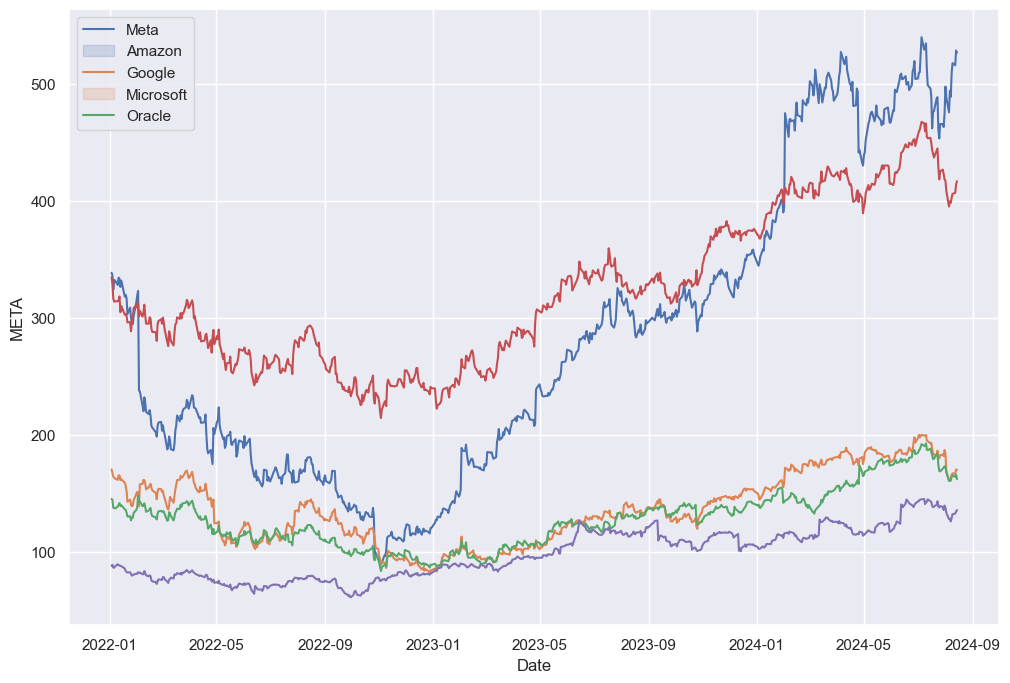

In [8]:
# Visualize data using seaborn
sns.set(rc={'figure.figsize':(12,8)})
sns.lineplot(x=data.index, y=data['META'])
sns.lineplot(x=data.index, y=data['AMZN'])
sns.lineplot(x=data.index, y=data['GOOG'])
sns.lineplot(x=data.index, y=data['MSFT'])
sns.lineplot(x=data.index, y=data['ORCL'])
plt.legend(labels = ['Meta', 'Amazon', 'Google', 'Microsoft', 'Oracle'])

In [9]:
import plotly.express as px


# Transformamos el DataFrame para que sea compatible con Plotly Express
df_melted = data.reset_index().melt(id_vars='Date', value_vars=['META', 'AMZN', 'GOOG', 'MSFT', 'ORCL'])
df_melted = df_melted.rename(columns={'index': 'Date', 'Ticker': 'Company', 'value': 'Stock Price'})

# Creamos la figura con Plotly Express
fig = px.line(df_melted, x='Date', y='Stock Price', color='Company')

# Actualizamos el layout para que se asemeje al estilo de Seaborn
fig.update_layout(
    title='Stock Prices Over Time',
    xaxis_title='',
    yaxis_title='Precio',
    legend_title='Company',
    template='plotly_white',
    width=1200, # Ancho de la figura
    height=800  # Altura de la figura
)

# Mostramos la figura
fig.show()


Hay 406 points para cada  ticker

In [10]:
#
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 657 entries, 2022-01-03 to 2024-08-14
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AMZN    657 non-null    float64
 1   GOOG    657 non-null    float64
 2   META    657 non-null    float64
 3   MSFT    657 non-null    float64
 4   ORCL    657 non-null    float64
dtypes: float64(5)
memory usage: 30.8 KB


# Paso 3: procesamiento de datos


El paso 3 transforma el conjunto de datos en un conjunto de datos de modelo de series temporales múltiples.

En primer lugar, el conjunto de datos se transforma del formato ancho al formato largo utilizando la `.melt` función pandas.

Prophet requiere al menos dos columnas como entradas: una `ds` columna y una `y` columna.

- La `ds` columna tiene la información de la hora. La columna `Date` pasa a llamarse `ds`.
- La `y` columna tiene los valores de la serie temporal. En este ejemplo, como estamos prediciendo el precio de cierre de las acciones, `y` representa el precio de cierre de las acciones.
- No hay un nombre predefinido para la serie temporal individual en Prophet, por lo que podemos mantener el nombre como está.

In [11]:

data = data.reset_index()
data


Ticker,Date,AMZN,GOOG,META,MSFT,ORCL
0,2022-01-03,170.404495,145.074493,338.540009,334.750000,87.900002
1,2022-01-04,167.522003,144.416504,336.529999,329.010010,88.839996
2,2022-01-05,164.356995,137.653503,324.170013,316.380005,86.459999
3,2022-01-06,163.253998,137.550995,332.459991,313.880005,86.339996
4,2022-01-07,162.554001,137.004501,331.790009,314.040009,87.510002
...,...,...,...,...,...,...
652,2024-08-08,165.800003,163.839996,509.630005,402.690002,128.960007
653,2024-08-09,166.940002,165.389999,517.770020,406.019989,132.059998
654,2024-08-12,166.800003,163.949997,515.950012,406.809998,132.580002
655,2024-08-13,170.229996,165.929993,528.539978,414.010010,134.259995


In [12]:
# Cambiar datos del formato ancho al formato largo
df = pd.melt(data, id_vars='Date', value_vars=["META",'AMZN',  'GOOG', 'MSFT', 'ORCL'])
df.columns = ['ds', 'ticker', 'y']


Después de transformar el conjunto de datos del formato ancho al formato largo, tenemos 2300 registros.

In [13]:
# revisar la informacion
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3285 entries, 0 to 3284
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      3285 non-null   datetime64[ns]
 1   ticker  3285 non-null   object        
 2   y       3285 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 77.1+ KB


A continuación, agrupamos el marco de datos de pandas por columna `ticker` y lo guardamos en un nuevo marco de datos llamado `groups_by_ticker`. Usando `.groups.keys()`, podemos confirmar que hay cinco grupos, un grupo para cada ticker.

In [14]:
# Agrupar los datos por ticker
groups_by_ticker = df.groupby('ticker')

# Verifique los grupos en el marco de datos
groups_by_ticker.groups.keys()

dict_keys(['AMZN', 'GOOG', 'META', 'MSFT', 'ORCL'])

#Paso 4: definir la función


En el paso 4 se define la función para entrenar y pronosticar cada grupo.

- Los datos de entrada son datos de series de tiempo individuales para un grupo.
- `Prophet()` inicia el modelo de serie temporal con los hiperparámetros predeterminados y le damos al modelo el nombre `m`. (ajuste de hiperparámetros).
- `m.fit(group)` ajusta el modelo del  en los datos de series de tiempo individuales, que son los datos del precio de las acciones para un ticker.
- `make_future_dataframe` crea un nuevo marco de datos llamado `future` para el pronóstico. `periods=15` significa que pronosticaremos 15 días de datos. Para utilizar una frecuencia diferente, podemos especificar la opción `freq` opción. Por ejemplo, `periods=15`, `freq='MS'`significa que estamos pronosticando para los próximos 15 meses.
- Después de predecir en el `future` marco de datos, Prophet produce una larga lista de resultados. Sólo mantuvimos `ds`, `yhat`, `yhat_lowery` `yhat_upper`. `yhat`es el valor predicho. `yhat_lowery` `yhat_upperson` el límite inferior y superior del intervalo de incertidumbre.
- `ticker` Se crea una nueva columna llamada en el marco de datos de pronóstico para indicar el nombre del teletipo de las predicciones.
La salida de la función tiene 5 columnas: `ds`, `ticker`, `yhat`, `yhat_uppery` `yhat_lower`.


In [15]:
def train_and_forecast(group):

  # crear el modelo
  m = Prophet()

  # entrenar el modelo
  m.fit(group)

  # Hacer predicciones
  future = m.make_future_dataframe(periods=15)
  forecast = m.predict(future)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
  forecast['ticker'] = group['ticker'].iloc[0]

  # forecast
  return forecast[['ds', 'ticker', 'yhat', 'yhat_upper', 'yhat_lower']]

# Paso 5: Pronóstico de múltiples series temporales usando For-Loop


En el paso 5, realizaremos pronósticos de múltiples series de tiempo utilizando el bucle for.

El tiempo utilizado para el pronóstico se calcula registrando el tiempo al principio y al final, obteniendo luego la diferencia entre los dos.
Se crea un marco de datos vacío para guardar los resultados del pronóstico.
Para cada ticker, primero obtenemos los datos de la serie temporal, luego aplicamos la función de entrenamiento y pronóstico a cada serie temporal individual y, finalmente, concatenamos los resultados del pronóstico.

In [16]:
# Tiempo de inicio
start_time = time()

# Dataframe vacio
for_loop_forecast = pd.DataFrame()


for ticker in ticker_list:
  # obtener datos para ticker
  group = groups_by_ticker.get_group(ticker)
  # pronostico
  forecast = train_and_forecast(group)
  # agregrae el resultado al dataframe
  for_loop_forecast = pd.concat((for_loop_forecast, forecast))

print(' Tiempo usada para el for-loop forecast es ', time()-start_time)

12:23:40 - cmdstanpy - INFO - Chain [1] start processing
12:23:41 - cmdstanpy - INFO - Chain [1] done processing
12:23:41 - cmdstanpy - INFO - Chain [1] start processing
12:23:41 - cmdstanpy - INFO - Chain [1] done processing
12:23:42 - cmdstanpy - INFO - Chain [1] start processing
12:23:42 - cmdstanpy - INFO - Chain [1] done processing
12:23:42 - cmdstanpy - INFO - Chain [1] start processing
12:23:43 - cmdstanpy - INFO - Chain [1] done processing
12:23:43 - cmdstanpy - INFO - Chain [1] start processing
12:23:43 - cmdstanpy - INFO - Chain [1] done processing


 Tiempo usada para el for-loop forecast es  3.0598955154418945


In [17]:
for_loop_forecast

,ds,ticker,yhat,yhat_upper,yhat_lower
0,2022-01-03,META,331.721172,349.623515,312.115334
1,2022-01-04,META,329.103208,348.892751,310.211016
2,2022-01-05,META,326.642812,346.225626,306.639444
3,2022-01-06,META,323.606182,343.077447,303.846469
4,2022-01-07,META,321.711133,340.036247,302.235282
...,...,...,...,...,...
667,2024-08-25,AMZN,191.938309,202.033906,181.733433
668,2024-08-26,AMZN,192.478897,202.914853,181.609079
669,2024-08-27,AMZN,192.008359,202.783088,182.174379
670,2024-08-28,AMZN,192.013481,202.375061,181.548052


# Paso 6: Pronóstico de múltiples series temporales mediante multiprocesamiento


En el paso 6, usaremos el multiprocessingpaquete Python para ejecutar los pronósticos de series temporales en paralelo.

- En  primer lugar, los datos de la serie temporal para cada ticker se guardan en una lista.
- En segundo lugar, un `pool` proceso en el que la cantidad de trabajadores es la cantidad de CPU. El pool objeto del multiprocessingpaquete Python ejecuta una función a través de datos de entrada en paralelo. cpu_count()devuelve el número de CPU en el sistema.
- imap es la versión paralela de map. Devuelve un objeto y los resultados deben convertirse en una lista. Usamos imappara aplicar la train_and_forcastfunción a cada elemento de la lista llamada serie, donde cada elemento es un marco de datos para un ticker individual.
- tqdm muestra la barra de progreso del entrenamiento.
- El resultado de la predicción es una lista de resultados de pronóstico, un marco de datos para cada ticker.
- El proceso del grupo debe finalizarse manualmente utilizando .close(). De lo contrario, el proceso puede quedar pendiente de su finalización.
- .join() le dice al grupo que espere hasta que finalicen todos los trabajos antes de salir.
- Finalmente, los resultados de todos los tickers se concatenan en un único marco de datos.

In [18]:
# tiempo de inicio
start_time = time()

# Obtener datos de series de tiempo para cada ticker y guardarlos en una lista
series = [groups_by_ticker.get_group(ticker) for ticker in ticker_list]

# Crear un proceso de grupo con el número de procesos de trabajo siendo el número de CPU
p = Pool(cpu_count())

# Hacer predicciones para cada ticker y guardar los resultados en una lista
predictions = list(tqdm(p.imap(train_and_forecast, series), total=len(series)))

# Terminar el proceso del grupo
p.close()

#  esperar hasta que finalicen todos los trabajos antes de salir
p.join()

# Concatenar resultado
multiprocess_forecast = pd.concat(predictions)

# Obtener el tiempo utilizado para el pronóstico
print('\nTiempo utilizado ', time()-start_time)

  0%|          | 0/5 [00:00<?, ?it/s]

: 

: 

In [ ]:
predictions

[            ds ticker        yhat  yhat_upper  yhat_lower
 0   2022-01-03   META  338.614267  353.176513  323.740462
 1   2022-01-04   META  335.511327  350.121659  321.558891
 2   2022-01-05   META  332.683841  346.414331  317.557890
 3   2022-01-06   META  329.719339  344.318802  315.546626
 4   2022-01-07   META  327.356888  342.502299  311.471828
 ..         ...    ...         ...         ...         ...
 562 2024-03-25   META  532.801902  548.487500  516.946881
 563 2024-03-26   META  535.112216  550.159282  520.367534
 564 2024-03-27   META  537.613084  552.736964  521.666410
 565 2024-03-28   META  539.875361  555.316467  524.457880
 566 2024-03-29   META  542.621548  557.224395  527.332545
 
 [567 rows x 5 columns],
             ds ticker        yhat  yhat_upper  yhat_lower
 0   2022-01-03   GOOG  138.965212  143.996197  133.826588
 1   2022-01-04   GOOG  138.888077  143.935675  134.067769
 2   2022-01-05   GOOG  138.769271  143.512901  133.543535
 3   2022-01-06   GOOG  138.8

# Paso 7: Pronóstico de múltiples series temporales usando Spark


En el paso 7, usaremos Spark para pronosticar múltiples series temporales en paralelo. Los trabajadores de un clúster Spark pueden entrenar y pronosticar un subconjunto de modelos en paralelo.

En primer lugar, spark se crea una sesión de Spark llamada. Podemos escribir el nombre de la sesión de Spark para verificar información como la versión de Spark.

In [18]:
# Importar Spark Session
from pyspark.sql import SparkSession
# Crear a sesion Spark
spark = SparkSession.builder.master("local[*]").getOrCreate()
# informacion de la sesion
spark

PySparkRuntimeError: [JAVA_GATEWAY_EXITED] Java gateway process exited before sending its port number.

A continuación, el marco de datos de Pandas se convierte en un marco de datos de Spark y se agrupa por ticker.

- `spark.createDataFrame` toma un marco de datos de pandas y lo convierte en un marco de datos de Spark.
- `applyInPandas` asigna cada grupo utilizando una UDF (función definida por el usuario) de pandas y devuelve un marco de datos.
- `schema` es un StructType que describe el esquema del marco de datos devuelto.

In [19]:
# Convertir el marco de datos de pandas en un marco de datos de Spark
sdf = spark.createDataFrame(df)

# Define el esquema de resultado
result_schema =StructType([
  StructField('ds',DateType()),
  StructField('ticker',StringType()),
  StructField('yhat',FloatType()),
  StructField('yhat_upper',FloatType()),
  StructField('yhat_lower',FloatType())
  ])

# Hora de inicio
start_time = time()

# Entrenamientro y pronostico por ticker
spark_forecast = sdf.groupBy('ticker').applyInPandas(train_and_forecast, schema=result_schema)

# resultados
spark_forecast.show(5)

# Tiempo de procesamiento
print('El tiempo utilizado para el pronóstico de Spark es ', time()-start_time)

NameError: name 'spark' is not defined

Otra forma de realizar pronósticos de múltiples series de tiempo es utilizarlo pandas_udfcomo decorador y aplicar la función al marco de datos de Spark agrupado. Sin embargo, se prefiere su uso `applyInPandas` en lugar de esta API porque quedará obsoleta en futuras versiones.



In [20]:
@pandas_udf( result_schema, PandasUDFType.GROUPED_MAP )
def train_and_forecast(group):

  # Initiate the model
  m = Prophet()

  # Fit the model
  m.fit(group)

  # Make predictions
  future = m.make_future_dataframe(periods=15)
  forecast = m.predict(future)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
  forecast['ticker'] = group['ticker'].iloc[0]

  # Return the forecasted results
  return forecast[['ds', 'ticker', 'yhat', 'yhat_upper', 'yhat_lower']]

# Tiempo inicio
start_time = time()

#
spark_forecast = sdf.groupBy('ticker').apply(train_and_forecast)

#
spark_forecast.show(5)

# Processing time
print('The time used for the Spark forecast is ', time()-start_time)

NameError: name 'result_schema' is not defined

# Paso 8: ¿Qué método utilizar?


Ahora que sabe cómo hacer pronósticos de múltiples series de tiempo usando un bucle for, multiprocesamiento y Spark, ¿qué método debería usar para su proyecto?

La pauta general es:

- Cuando el número de modelos es pequeño, no hay una gran diferencia en el tiempo de procesamiento, por lo que es bueno utilizar cualquiera de los tres métodos.
- Cuando la cantidad de modelos es media, use multiprocesamiento o Spark para utilizar múltiples CPU en paralelo.
- Cuando la cantidad de modelos es grande, se prefiere Spark.

# References

* [Multiprocessing — Process-based parallelism documentation](https://docs.python.org/3/library/multiprocessing.html)
* [PySpark documentation on applyInPandas](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.GroupedData.applyInPandas.html?highlight=applyinpandas#pyspark.sql.GroupedData.applyInPandas)
* [Fine-Grained Time Series Forecasting At Scale With Facebook Prophet And Apache Spark](https://databricks.com/blog/2020/01/27/time-series-forecasting-prophet-spark.html)
* [Prophet documentation on non-daily data](https://facebook.github.io/prophet/docs/non-daily_data.html)